<a href="https://colab.research.google.com/github/Vishesh-tamrakar/Upskill_Quality_Prediction/blob/main/UpSkill_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project10 : QUALITY PREDICTION IN A MINING PROCESS**
---
---




###Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


The dataset was obtained from a mineral processing plant which separated silica from iron ore using the reverse cationic flotation method. Continuous processing data was collected from 1:00 A.M. on 10th March 2017 to 11:00 P.M. on 9th September 2017.

Each row of data consists of 23 measurements that can be categorized into these four categories which are as follows :

* raw materials (column 2-3);
* environment variables (column 4-8);
* process variables (column 9-22);
* processed materials (column 23-24).

NOTE:

Raw materials and processed materials were sampled on an hourly basis while the others were sampled every 20 second.

In [ ]:
url = 'https://media.githubusercontent.com/media/Vishesh-tamrakar/Upskill_Quality_Prediction/main/MiningProcess_Flotation_Plant_Database.csv'
cols_renamed = [
    'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    'air_col2',
    'air_col3',
    'air_col4',
    'air_col5',
    'air_col6',
    'air_col7',
    'level_col1',    # Froth height in the cell, measured in mm
    'level_col2',
    'level_col3',
    'level_col4',
    'level_col5',
    'level_col6',
    'level_col7',
    'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    'conc_silica']   # Lab measurement: %Silica in the end of flotation process
df = pd.read_csv(
    url,
    header=0,
    names=cols_renamed,
    parse_dates=['date'],
    infer_datetime_format=True,
    decimal=',')
df.head()

,date,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,...,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


Importing the provided dataset with the help of the github repository url.

Changing the column names so as to make the dataset easier to interpret thereby also replacing the “ , “ symbol to “ . “ symbol for our understanding and computations.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          737453 non-null  datetime64[ns]
 1   feed_iron     737453 non-null  float64       
 2   feed_silica   737453 non-null  float64       
 3   starch_flow   737453 non-null  float64       
 4   amina_flow    737453 non-null  float64       
 5   pulp_flow     737453 non-null  float64       
 6   pulp_ph       737453 non-null  float64       
 7   pulp_density  737453 non-null  float64       
 8   air_col1      737453 non-null  float64       
 9   air_col2      737453 non-null  float64       
 10  air_col3      737453 non-null  float64       
 11  air_col4      737453 non-null  float64       
 12  air_col5      737453 non-null  float64       
 13  air_col6      737453 non-null  float64       
 14  air_col7      737453 non-null  float64       
 15  level_col1    737

Here we looked at the preliminary information regarding the data set such as range, datatype and memory usage before proceeding towards the opeartions of preprocessing.

## % SILICA CONCENTRATION FORECAST TIME CALCULATION
---



###Preprocessing Time-Series Data

Column date is being resampled to reduce the frequency of the provided time-series data into an hourly basis which is achieved by selecting only the first measurements of each hour from the dataset.

In [ ]:
# Resample data to hourly basis
df = df.set_index('date').resample('H').first()
df.shape

(4415, 23)

In [ ]:
nans = df[df.isna().any(axis=1)]  # Check for missing values
print(f'Total rows with NaNs: {nans.shape[0]}\n')
nans

Total rows with NaNs: 318



,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,...,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,
2017-03-16 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-29 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Upon inspecting the data, 318 rows containing missing values are found between 2017-03-16 06:00 to 2017-03-29 11:00.

Missing values may introduce discontinuity in the time-series data which may result detrimental to our forecast. Therefore, only the data starting from 2017-03-29 12:00 will be used further.

In [ ]:
# Remove data with time discontinuity
df = df['2017-03-29 12:00:00':]
df

,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,...,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,2044.990000,349.911,405.625000,9.74604,1.649650,200.393,195.734,201.826,...,251.002,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,2510.360000,306.635,402.303000,9.63786,1.524512,200.165,194.286,201.929,...,250.188,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,2138.230000,435.199,401.953000,9.61320,1.594940,199.540,197.436,198.605,...,250.488,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,458.079000,476.878,400.173000,9.75149,1.638440,199.951,191.456,199.265,...,249.582,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157,66.41,1.27
2017-03-29 16:00:00,59.54,9.56,145.349632,252.088,399.484000,9.96978,1.521080,199.072,182.430,201.251,...,250.760,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,2888.060000,494.990,376.468000,9.27990,1.667860,317.065,297.754,301.685,...,302.330,577.943000,489.959000,504.995000,440.587,481.295,434.701,401.796,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4218.570000,492.027,378.630000,9.15799,1.648880,302.081,301.348,300.543,...,342.615,412.491000,510.388000,342.202000,371.883,594.518,443.687,375.044,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,3159.100000,520.986,381.468667,9.58069,1.736200,296.063,298.480,299.085,...,332.393,401.456000,533.409000,390.060000,395.463,587.855,489.406,504.982,64.29,1.80


The following plot shows the mineral content before (i.e., in the feed) and after flotation process (in the concentrate). As it can be observed from the figure, the purpose of flotation is to increase recovery of iron mineral while reducing the gangue (silica).

During some periods (e.g., May 13 to June 13), mineral content in the feed was constant but the resulting content in the concentrate fluctuate this suggests that % iron and % silica in concentrate are not solely governed by the content of raw materials but other parameters as well (i.e., environment, process variables).

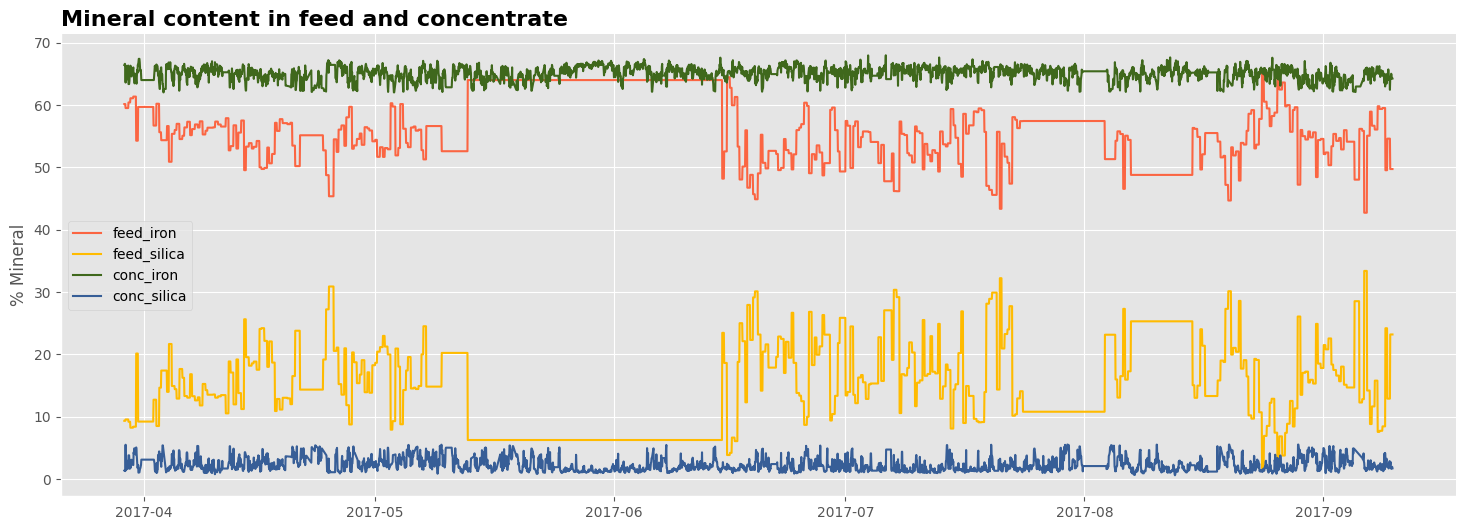

In [ ]:
content = ['feed_iron', 'feed_silica', 'conc_iron', 'conc_silica']
palette = ['#FB6542', '#FFBB00', '#3F681C', '#375E97']

# Plot mineral content before and after flotation
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
for pct, color in zip(content, palette):
    ax.plot(df.index.values, pct, data=df, color=color)
ax.set_title('Mineral content in feed and concentrate',
             loc='left', weight='bold', size=16)
ax.set_ylabel('% Mineral')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center left')
plt.show()

The column conc_iron is dropped from the dataframe here because we want to perform forecasting % silica in concentrate without including % iron in concentrate as a feature. The data are then normalized as they have different units and scales.

In [ ]:
cols = list(df)
cols.insert(0, cols.pop(         # Moving target `conc_silica` to the front
    cols.index('conc_silica')))  # Not necessary but I prefer to do so
df = df.loc[:, cols]
df.to_csv('./Flotation_Dataset_by_Hour.csv')  # For safekeeping

# Drop `conc_iron` then normalize all data
values = df.drop('conc_iron', axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0]  # Show first element of the array

array([0.15415822, 0.75694444, 0.25023372, 0.32510961, 0.21746036,
       0.69332766, 0.4831859 , 0.38984084, 0.12485375, 0.09580737,
       0.19501985, 0.14419899, 0.94633739, 0.32903284, 0.31764479,
       0.56808723, 0.55238373, 0.64222035, 0.51514011, 0.48621123,
       0.53465188, 0.59964695])

The preprocessing stage involves framing the dataset as a supervised learning problem where we forecast the % silica in concentrate at the current hour (t) given the parameters (i.e., raw materials, environment, process) in prior time steps (t-n) therefore we transform the dataset using the series_to_supervised() function below.

In [ ]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):   # Input sequence (t-n, ... t-1)
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):      # Forecast sequence (t, t+1, ... t+n)
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)  # Put it all together
    agg.columns = names
    if dropnan:                    # Drop rows with NaN values
        agg.dropna(inplace=True)

    # Drop columns we don't want to predict
    drop_cols = ['var'+str(i)+'(t)' for i in range(2,23)]
    agg.drop(columns=drop_cols, axis=1, inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(scaled, n_in=1, n_out=1)
reframed  # Show reframed dataset

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var1(t)
1,0.154158,0.756944,0.250234,0.325110,0.217460,0.693328,0.483186,0.389841,0.124854,0.095807,...,0.329033,0.317645,0.568087,0.552384,0.642220,0.515140,0.486211,0.534652,0.599647,0.168357
2,0.168357,0.756944,0.250234,0.399114,0.130491,0.614810,0.430529,0.014039,0.123694,0.088174,...,0.326752,0.313026,0.986143,0.969781,0.992805,0.552195,0.501239,0.532443,0.492095,0.148073
3,0.148073,0.756944,0.250234,0.339937,0.388859,0.606538,0.418525,0.225542,0.120515,0.104780,...,0.328243,0.314728,0.984364,0.912104,1.000000,0.596969,0.568442,0.552298,0.582143,0.135903
4,0.135903,0.756944,0.250234,0.072755,0.472618,0.564466,0.485839,0.356177,0.122605,0.073255,...,0.313385,0.309587,0.994997,0.918708,0.996056,0.533758,0.551708,0.488795,0.637805,0.993915
5,0.993915,0.729167,0.257089,0.023025,0.020871,0.548181,0.592093,0.003732,0.118134,0.025672,...,0.328400,0.316272,0.988924,0.925313,0.995976,0.528430,0.527645,0.543158,0.541217,0.210953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,0.249493,0.304253,0.682144,0.494607,0.513934,0.163464,0.328183,0.396119,0.628798,0.675804,...,0.614199,0.584263,0.365708,0.488878,0.344877,0.427605,0.573162,0.428127,0.373888,0.212982
3944,0.212982,0.304253,0.682144,0.459176,0.509017,0.004184,0.256289,0.444529,0.718317,0.633630,...,0.592163,0.608914,0.600062,0.451446,0.497431,0.538709,0.619649,0.510174,0.468046,0.225152
3945,0.225152,0.304253,0.682144,0.670757,0.503062,0.055284,0.196949,0.387530,0.642099,0.652577,...,0.809050,0.837517,0.366786,0.484547,0.283132,0.405512,0.843034,0.526855,0.412228,0.243408
3946,0.243408,0.304253,0.682144,0.502278,0.561259,0.122377,0.402701,0.649761,0.611488,0.637457,...,0.889766,0.779511,0.351228,0.521847,0.346131,0.451227,0.829888,0.611724,0.683342,0.275862


Column var1(t-1) to var22(t-1) are our features/inputs. Measured values of the inputs are lagged 1 hour before the target var1(t) (% silica in concentrate at time t).

Transformed data is further split into three sets:

training (60%), validation (20%), and testing (20%).

Flotation data in the period between 2017-03-29 12:00 and 2017-08-08 00:00 is used for training/validation purpose, totaling 3157 hours.

In [ ]:
n_features = 22             # Number of inputs for forecast
n_hours = 1                 # Number of hours with which to lag features
n_obs = n_hours*n_features

# Define row size of each split
n_train = int(np.round(len(reframed)*.60))
n_valid = int(np.round(len(reframed)*.20))
n_test = int(np.round(len(reframed)*.20))

# Split dataset by row size
values = reframed.values
train = values[:n_train, :]
valid = values[n_train:(n_train+n_valid), :]
test = values[(n_train+n_valid):, :]

# Each set further split into inputs/features (X) and output (y)
train_X, train_y = train[:, :n_obs], train[:, -1]
valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

# Reshape inputs (X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print(  # Show the final shape of each set
    f'Training set  : {train_X.shape}, {train_y.shape}',
    f'\nValidation set: {valid_X.shape}, {valid_y.shape}',
    f'\nTesting set   : {test_X.shape}, {test_y.shape}')

Training set  : (2368, 1, 22), (2368,) 
Validation set: (789, 1, 22), (789,) 
Testing set   : (790, 1, 22), (790,)


###Building And Training Model

Forecasting gangue present in flotation concentrate is a time-series related problem. A variation of the recurrent neural networks (RNN), called the long short-term memory (LSTM), is a deep learning approach which can be implemented to solve this problem.

Model construction and training is done with Keras - a Python deep learning library. The model is made up of two LSTM layers : each with 16 memory cells followed by a fully-connected (Dense) layer.

In training, the data are grouped into mini batches of 16 training samples. The training process is run for 100 epochs (one epoch is the number of passes needed to complete the entire training samples).

In [ ]:
model = Sequential([   # Define a sequential model
    LSTM(units=16,
         return_sequences=True,
         input_shape=(train_X.shape[1],
                      train_X.shape[2])),
    LSTM(units=16),
    Dense(1)
])
model.compile(
    loss='mae',        # Mean absolute error
    optimizer='adam')  # Learning rate = 0.001
model.summary()        # Display model's architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             2496      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(   # Fit on training data
    train_X,
    train_y,
    epochs=100,
    batch_size=16,
    validation_data=(  # Supply validation data
        valid_X,
        valid_y),
    verbose=2,
    shuffle=False,
    callbacks=ModelCheckpoint(  # Save model
        './LSTM_Flotation_Gangue.hdf5'))

Epoch 1/100
148/148 - 5s - loss: 0.2176 - val_loss: 0.1527 - 5s/epoch - 33ms/step
Epoch 2/100
148/148 - 1s - loss: 0.1694 - val_loss: 0.1490 - 502ms/epoch - 3ms/step
Epoch 3/100
148/148 - 1s - loss: 0.1535 - val_loss: 0.1403 - 710ms/epoch - 5ms/step
Epoch 4/100
148/148 - 1s - loss: 0.1277 - val_loss: 0.1216 - 793ms/epoch - 5ms/step
Epoch 5/100
148/148 - 1s - loss: 0.1117 - val_loss: 0.1092 - 731ms/epoch - 5ms/step
Epoch 6/100
148/148 - 1s - loss: 0.1052 - val_loss: 0.1013 - 695ms/epoch - 5ms/step
Epoch 7/100
148/148 - 1s - loss: 0.1014 - val_loss: 0.0953 - 579ms/epoch - 4ms/step
Epoch 8/100
148/148 - 1s - loss: 0.0982 - val_loss: 0.0931 - 570ms/epoch - 4ms/step
Epoch 9/100
148/148 - 1s - loss: 0.0967 - val_loss: 0.0917 - 578ms/epoch - 4ms/step
Epoch 10/100
148/148 - 0s - loss: 0.0966 - val_loss: 0.0913 - 497ms/epoch - 3ms/step
Epoch 11/100
148/148 - 0s - loss: 0.0965 - val_loss: 0.0907 - 489ms/epoch - 3ms/step
Epoch 12/100
148/148 - 0s - loss: 0.0965 - val_loss: 0.0905 - 492ms/epoch - 

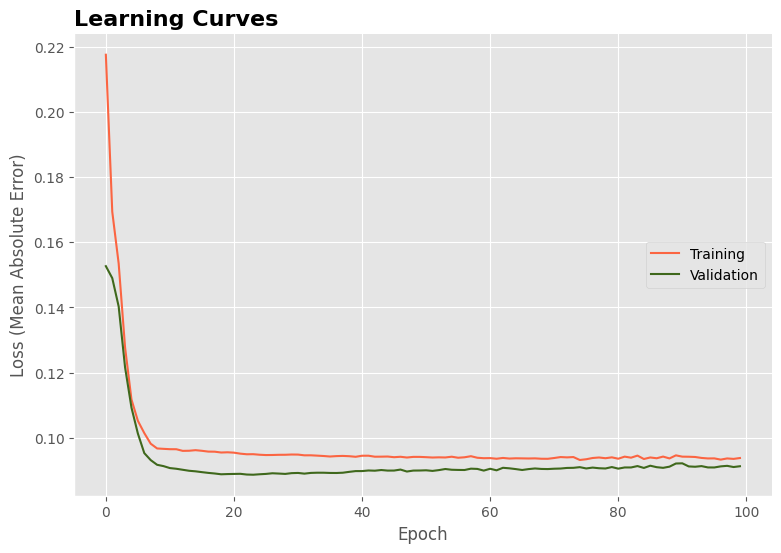

In [ ]:
# Extract losses from training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Plot learning curves
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(train_loss, color=palette[0], label='Training')
ax.plot(valid_loss, color=palette[2], label='Validation')
ax.set_title('Learning Curves', loc='left', weight='bold', size=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Mean Absolute Error)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center right')
plt.show()

The plot above indicates that the model exhibits a good fit where the training and validation losses decrease to a point of stability and there is minimal gap between the two values.

In [ ]:
print(f'Best training loss   = {min(train_loss):.4f}',
      f'at epoch {train_loss.index(min(train_loss))}',
      f'\nBest validation loss = {min(valid_loss):.4f}',
      f'at epoch {valid_loss.index(min(valid_loss))}')

Best training loss   = 0.0932 at epoch 74 
Best validation loss = 0.0886 at epoch 23


###Forecasting With LSTM

Forecasting is performed using the trained model and on the data that was not included during training/validation process. Forecasts and actual values are inverted back into their original scales before calculating error scores for the model. Two error metrics are considered here in the forecast evaluation: (1) mean absolute error, and (2) root mean squared error.

In [ ]:
# Make prediction using test features
yhat = model.predict(test_X)

# Reshape test data
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_y = test_y.reshape((len(test_y), 1))

# Invert scaling for forecasts
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate error scores
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMean absolute error    : {mae:.4f}',
      f'\nRoot mean squared error: {rmse:.4f}')

26/26 [==============================] - 1s 2ms/step
--------------------------------
FORECAST EVALUATION
-------------------------------- 
Mean absolute error    : 0.4970 
Root mean squared error: 0.7085


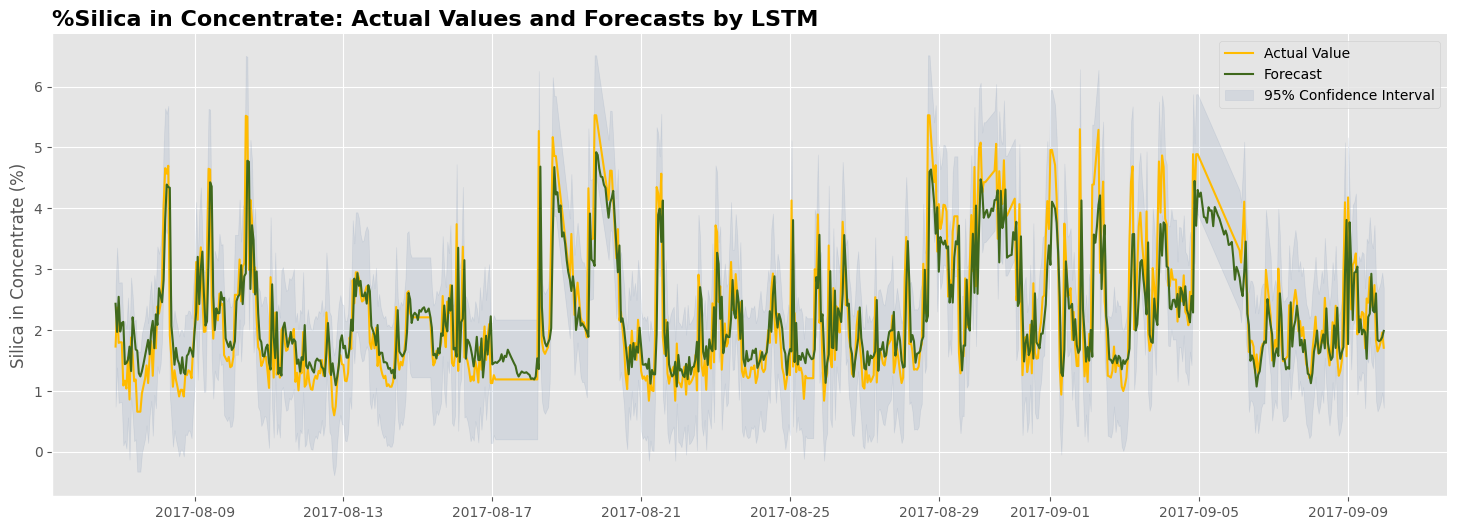

In [ ]:
# Define date as x-axis
test_date = df.index[-test_y.shape[0]:]

# Confidence interval 95% (Z-value 1.96)
ci = 1.96*np.std(inv_y)/np.mean(inv_y)

# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(test_date, inv_y, color=palette[1], label='Actual Value')
ax.plot(test_date, inv_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (inv_y-ci), (inv_y+ci), color=palette[3],
                alpha=.1, label='95% Confidence Interval')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by LSTM',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

A comparison of forecasts and actual values of % silica in concentrate is displayed above for the period between 1 A.M. 8th August 2017 and 11 P.M. 9th September 2017.

The forecasts largely follow the pattern of actual values and are contained within the 95% confidence interval.

###Forecast With Random Forest

A random forest regressor, in comparison to LSTM, generates greater error and may not perform as well for long-term forecast.

In [ ]:
# Reframe data by lagging features by 1 hour
rf_values = df.drop('conc_iron', axis=1).values
rf_reframed = series_to_supervised(rf_values, n_in=1, n_out=1)

# Define features and target
rf_X = rf_reframed.values[:, :-1]
rf_y = rf_reframed.values[:, -1]

# Split data into train/test sets (80/20)
rf_train_X, rf_test_X, rf_train_y, rf_test_y = train_test_split(
    rf_X, rf_y, test_size=.20, random_state=0, shuffle=False)

# Normalize features
rf_scaler = MinMaxScaler(feature_range=(0,1))
rf_train_X = rf_scaler.fit_transform(rf_train_X)
rf_test_X = rf_scaler.transform(rf_test_X)

# Instantiate regressor
forest = RandomForestRegressor(random_state=0)

# Fit model on training data
forest.fit(rf_train_X, rf_train_y)

# Make prediction using trained model
rf_yhat = forest.predict(rf_test_X)

# Calculate error scores
rf_mae = mean_absolute_error(rf_test_y, rf_yhat)
rf_rmse = np.sqrt(mean_squared_error(rf_test_y, rf_yhat))
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMean absolute error    : {rf_mae:.4f}',
      f'\nRoot mean squared error: {rf_rmse:.4f}')

--------------------------------
FORECAST EVALUATION
-------------------------------- 
Mean absolute error    : 0.6068 
Root mean squared error: 0.7773


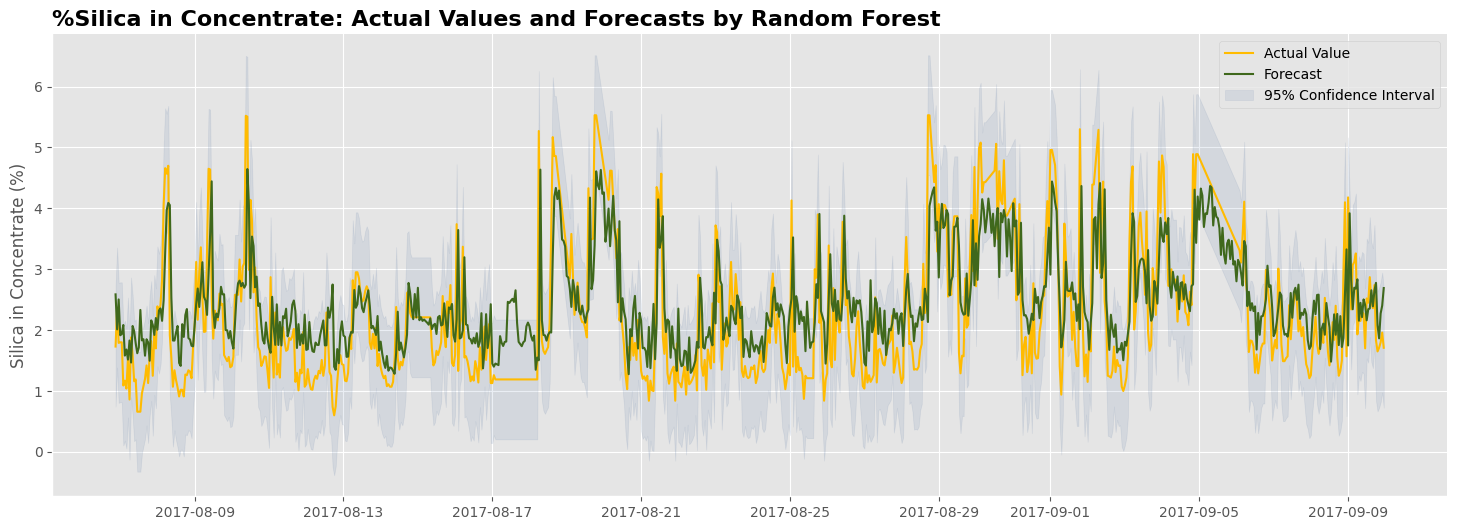

In [ ]:
# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(test_date, rf_test_y, color=palette[1], label='Actual Value')
ax.plot(test_date, rf_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (rf_test_y-ci), (rf_test_y+ci), color=palette[3],
                alpha=.1, label='95% Confidence Interval')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by Random Forest',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
df

,conc_silica,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,...,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,1.31,55.20,16.98,3019.530,557.434,395.713000,10.06640,1.74000,249.214,253.235,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91
2017-03-10 02:00:00,1.11,55.20,16.98,3170.410,539.673,399.697000,10.15890,1.66910,249.291,248.269,...,250.488,249.774,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06
2017-03-10 03:00:00,1.27,55.20,16.98,3365.650,573.517,399.023000,10.08600,1.70565,249.379,253.312,...,250.829,249.060,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97
2017-03-10 04:00:00,1.36,55.20,16.98,2693.750,592.133,409.204000,9.94880,1.72472,248.302,251.906,...,252.081,249.236,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75
2017-03-10 05:00:00,1.34,55.20,16.98,2352.216,601.807,398.145000,9.84375,1.75928,248.950,246.313,...,252.686,252.686,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,1.65,49.75,23.20,2888.060,494.990,376.468000,9.27990,1.66786,317.065,297.754,...,297.551,302.330,577.943,489.959,504.995,440.587,481.295,434.701,401.796,65.05
2017-09-09 20:00:00,1.71,49.75,23.20,4218.570,492.027,378.630000,9.15799,1.64888,302.081,301.348,...,336.250,342.615,412.491,510.388,342.202,371.883,594.518,443.687,375.044,64.83
2017-09-09 21:00:00,1.80,49.75,23.20,3159.100,520.986,381.468667,9.58069,1.73620,296.063,298.480,...,350.652,332.393,401.456,533.409,390.060,395.463,587.855,489.406,504.982,64.29


The final table generated after the applied computations is given above

##CONCLUSION

Deep learning approach using LSTM was implemented to forecast gangue content in flotation concentrate.

Excluding % iron in concentrate from the features, % silica in concentrate were forecasted one hour ahead and with error below 1 (based on RMSE, MAE). As per the dataset MAE and RMSE of 1±0.2 is a satisfactory result. The forecasts thus show a promising method for the engineers to make timely assessments of concentrate purity and take corrective actions in advance, especially when purity deviates from the acceptable values.

Finally, although LSTM implementation in this experiment has met the objectives, it will benefit from further exploration:

●	Forecasting with smaller lag timesteps. For example, a 30-minute lag for the features/inputs.

●	Analysis of feature importance in order to understand which parameters of the flotation process greatly affect %silica in concentrate. This ensures that the important parameters are adjusted accordingly.


#PREDICTION OF % SILICA CONCENTRATE WITH AND WITHOUT USING % IRON CONCENTRATE COLUMN

---




In [ ]:
url = 'https://media.githubusercontent.com/media/Vishesh-tamrakar/Upskill_Quality_Prediction/main/MiningProcess_Flotation_Plant_Database.csv'
data = pd.read_csv(url)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

Here we looked at the preliminary information regarding the data set such as range, datatype and memory usage before proceeding towards the opeartions of preprocessing.

In [ ]:
data.isna().sum()

date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

Performing check to make sure there are 0 null values.

###Preprocessing The Data

In [ ]:
for column in data.columns:
    data[column] = data[column].apply(lambda x: x.replace(',', '.'))

We replaced the “ , “ symbol to “ . “ for our understanding.

In [ ]:
data

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.37,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.56,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.068,1.74,249.741,247.874,...,248.071,451.24,468.927,434.61,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.21,471.411,437.69,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.9,450.523,453.67,462.598,443.682,425.679,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.2,2710.94,441.052,386.57,9.62129,1.65365,302.344,298.786,...,313.695,392.16,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71
737449,2017-09-09 23:00:00,49.75,23.2,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,236.7,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71
737450,2017-09-09 23:00:00,49.75,23.2,2692.2,500.488,383.496,9.61874,1.65338,303.662,307.397,...,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.13,64.27,1.71
737451,2017-09-09 23:00:00,49.75,23.2,1164.12,491.548,384.976,9.61686,1.65324,302.55,301.959,...,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71


###Feature Engineering

In [ ]:
data['date'] = data['date'].apply(lambda x: re.search('[0-9]*-[0-9]*', x).group(0))

data['Year'] = data['date'].apply(lambda x: re.search('^[^-]*', x).group(0))
data['Month'] = data['date'].apply(lambda x: re.search('[^-]*$', x).group(0))

data = data.drop('date', axis=1)

In [ ]:
data = data.astype(np.float)

<ipython-input-7-bd93a00e21b0>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


In [ ]:
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Month
0,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31,3.0
1,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31,3.0
2,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31,3.0
3,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31,3.0
4,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,249.895,...,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,...,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71,9.0
737449,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,...,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71,9.0
737450,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,...,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71,9.0
737451,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,298.045,...,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71,9.0


Modifying the date column in the dataset such that only the year and month are displayed seperately in individual columns and also dropping the previously present date column. We then converted from string datatype to float.  

###Visualization

In [ ]:
data['Year'].unique()

array([2017.])

In [ ]:
data = data.drop('Year', axis=1)

The dataset contains a unique value which we would remove while visualizing the data via a seaborn heatmap.

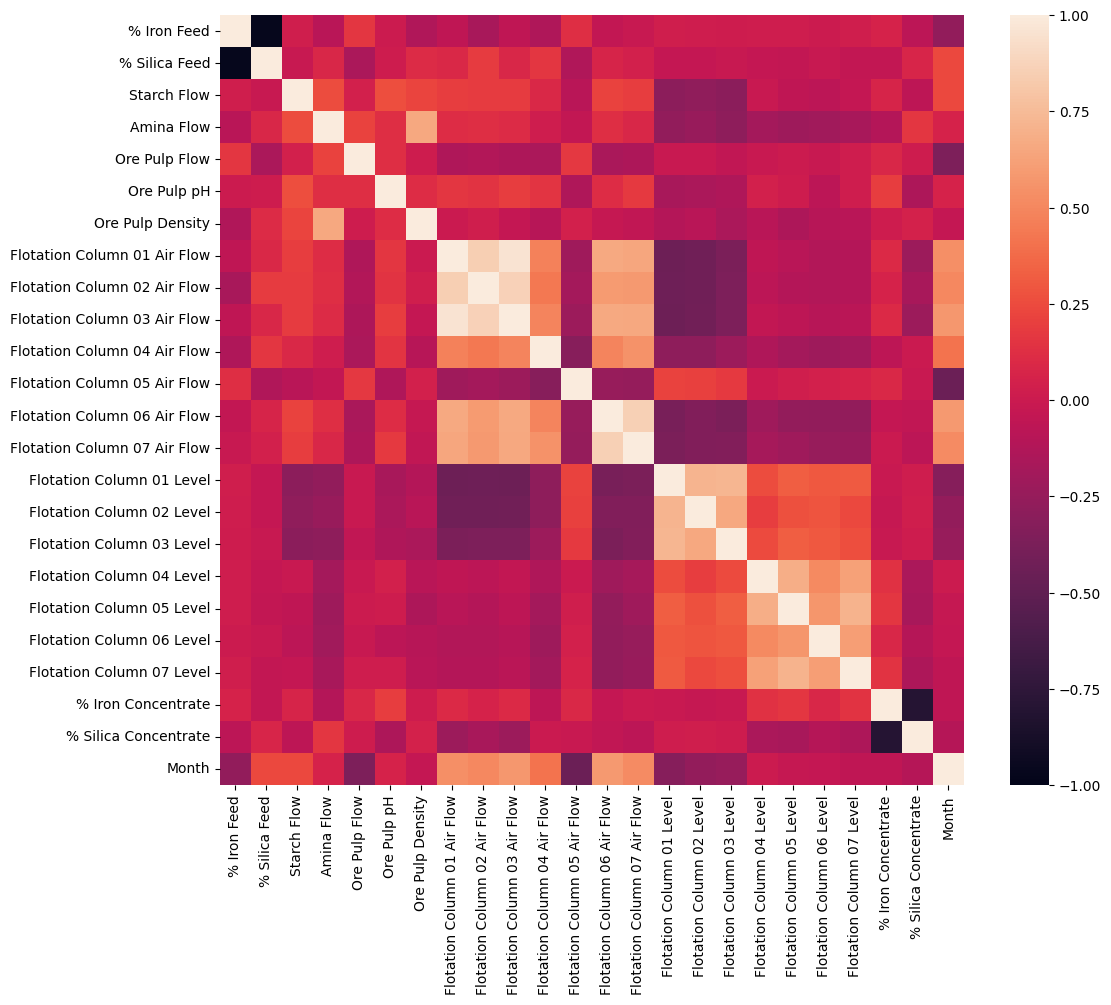

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), vmin=-1.0, vmax=1.0)
plt.show()

Here We can clearly see that % Silica Concentration and % Iron Concentration are highly correlated

#Splitting And Scaling

In [ ]:
target = '% Silica Concentrate'

y = data[target]

X_n = data.drop([target, '% Iron Concentrate'], axis=1)
X_i = data.drop(target, axis=1)

As we are instructed to check the correlation of % Iron Concentrate with % Silica Concentrate and the possibility of predicting % Silica Concentrate without using % Iron Conentrate we are performing splitting and scaling operation.

Y represents % Silica Concentrate which is our target

X_n represents dataset without % Iron Concentrate

X_i represents dataset with % Iron Concentrate

In [ ]:
scaler = StandardScaler()

X_n = scaler.fit_transform(X_n)
X_i = scaler.fit_transform(X_i)

In [ ]:
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y, train_size=0.7)
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y, train_size=0.7)

###Training

In [ ]:
model_n = LinearRegression()
model_i = LinearRegression()

Two models are created with Linear Regression for our provided task where

model_n repesents model without % Iron Concentrate i.e. Y & X_n

model_i represents model with % Iron Concentrate i.e. Y & X_i

In [ ]:
model_n.fit(X_n_train, y_n_train)
print("Model without iron R^2 Score:", model_n.score(X_n_test, y_n_test))

Model without iron R^2 Score: 0.1548157163745284


In [ ]:
model_i.fit(X_i_train, y_i_train)
print("Model with iron R^2 Score:", model_i.score(X_i_test, y_i_test))

Model with iron R^2 Score: 0.6878134627179113


In [ ]:
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Month
0,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31,3.0
1,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31,3.0
2,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31,3.0
3,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31,3.0
4,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,249.895,...,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,...,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71,9.0
737449,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,...,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71,9.0
737450,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,...,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71,9.0
737451,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,298.045,...,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71,9.0


##CONCLUSION

Yes, It is possible to predict % Silica in Concentrate without using % Iron Concentrate column.
But here we also observe that the R^2 value with inclusion of % Iron Concentrate column is greater that when not included that means it did really helped in the prediction because of the high correlation between them .